## collecting Data sample

In [2]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer




con = sqlite3.connect('./amazon-fine-food-reviews/database.sqlite') 
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con)

In [3]:
s1= filtered_data.loc[filtered_data["Score"]>=4].sample(n=2000,random_state=5)
print(s1.shape)

s2= filtered_data.loc[filtered_data["Score"]<=2].sample(n=2000,random_state=127)
print(s2.shape)

(2000, 10)
(2000, 10)


In [4]:
data=s1
data=data.append(s2)
data.shape

(4000, 10)

In [5]:
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
data['Score'] = positiveNegative

In [6]:
sorted_data=data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(3949, 10)

In [7]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final=final.drop_duplicates(subset={"UserId","ProfileName","Time"},keep='first',inplace=False)
final.shape

(3939, 10)

In [8]:
final['Score'].value_counts()

positive    1992
negative    1947
Name: Score, dtype: int64

## Text preprocessing

In [9]:
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    


5
Beetlejuice is Tim Burton's 2nd film after Pee Wee's Big Adventure and it's his most popular next to Batman. A lot of films such as Monkey Bone have tried to copy it's strange originality and have failed. It wasn't the best reviewed movie when it came out but that's because critics most likely didn't know what to think about it.<p>  It has fun effects, a wacky and energetic performance by Michael Keaton and an original plot. After all these years there's still nothing quite like Beetle Juice. I mean what other movie has giant sand worms that eat dead people ?


In [10]:
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english') 

def cleanhtml(sentence): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print(sno.stem('tasty'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\santosh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
{"weren't", "aren't", 'a', 'below', 'be', 'who', 'is', 'not', "you've", 'there', 'wouldn', "mightn't", 'until', 'didn', 'won', 'no', 'very', 'we', 'it', 'all', 'over', 'if', 'weren', 'during', 'how', 'them', 've', 'that', 'had', 'have', "it's", "should've", 'through', 'of', 't', 'just', 'my', 'should', 'our', 'he', 'off', 'shan', 'me', 'why', 'shouldn', 'yourselves', 'by', 'am', 'about', 'above', 'was', 'hers', 'each', "needn't", 'out', "you'll", 'while', "hadn't", 'doesn', 'between', "wasn't", 'this', 's', 'which', 'once', 'both', "don't", 'herself', "wouldn't", 'down', 'the', 'against', 'those', 'd', 'needn', 'his', 'aren', 'couldn', "she's", 'with', 'they', 'own', 'further', 'themselves', 'being', 'some', 'because', 'again', 'myself', 'into', 'more', 'at', 'in', 'do', 'll', "couldn't", 'to', 'under', 'haven', "won't", 'will

In [12]:
i=0
str1=' '
final_string=[]
all_positive_words=[] 
all_negative_words=[] 
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    
    sent=cleanhtml(sent) 
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) 
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) 
                else:
                    continue
            else:
                continue 

    str1 = b" ".join(filtered_sentence)
    
    final_string.append(str1)
    i+=1

In [14]:
final['CleanedText']=final_string
final.head(3) 


conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None,
             dtype=None)
final.shape

(3939, 11)

## timestamp based sort

In [69]:
final=final.sort_values('Time')


In [71]:
x= np.array(final.iloc[:, 0:10])

In [81]:
y= np.array(final['Score'])


## Knn for Bag Of Words

In [16]:

from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation

C:\Users\santosh\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [87]:
count_vect = CountVectorizer()
final_bow = count_vect.fit_transform(x[:,9])


In [92]:
final_bow.get_shape()

(4000, 13940)

In [94]:
X_1, X_test, y_1, y_test = cross_validation.train_test_split(final_bow, y, test_size=0.3)

X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)


In [96]:
for i in range(1,20,2):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_tr, y_tr)
    pred = knn.predict(X_cv)
    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy for k = %d is %d%%' % (i, acc))
    


CV accuracy for k = 1 is 58%

CV accuracy for k = 3 is 61%

CV accuracy for k = 5 is 61%

CV accuracy for k = 7 is 60%

CV accuracy for k = 9 is 62%

CV accuracy for k = 11 is 60%

CV accuracy for k = 13 is 59%

CV accuracy for k = 15 is 59%

CV accuracy for k = 17 is 60%

CV accuracy for k = 19 is 60%


In [104]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_tr,y_tr)
pred = knn.predict(X_test)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print(acc)

60.75000000000001



The optimal number of neighbors is 9.


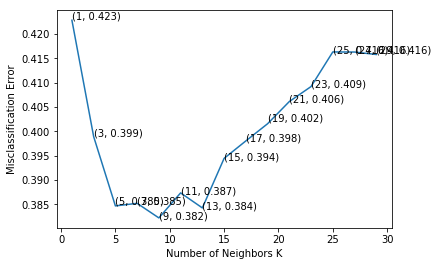

the misclassification error for each k value is :  [0.423 0.399 0.385 0.385 0.382 0.387 0.384 0.394 0.398 0.402 0.406 0.409
 0.416 0.416 0.416]


In [99]:
myList = list(range(0,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

cv_scores = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_tr, y_tr, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

MSE = [1 - x for x in cv_scores]

optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [101]:

knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

knn_optimal.fit(X_tr, y_tr)

pred = knn_optimal.predict(X_test)

acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 9 is 60.750000%


## Observation:
- on doing the k-nn by bag of words vectorizing.the results are as follows:
 - on k-nn cv there is 60.75 accuracy for test data and 62 accuracy for cv-data.
 - on k-fold there is 60.75 accuracy with the optimal k value as 9

## K-nn for TF-IDF

In [105]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(x[:,9])
final_tf_idf.get_shape()

(4000, 145687)